In [1]:
import numpy as np
import matplotlib.pyplot as plt
from math import pi
plt.rcParams['image.cmap'] = 'jet'
plt.rcParams['figure.facecolor'] = 'white'

Xdict = {}
Pdict = {}

In [2]:
def phi_anisotropic(kx, ky, F4, l):
    k = np.sqrt(kx * kx + ky * ky)
    return k * np.exp(-kx*kx / F4) / ((kx + l*1.0j) * (kx + l*1.0j) - k)

def calculate_wake(F, l=0.01, kmax=128, d=0.125):
    k = np.arange(-kmax, kmax+d, d)
    n = len(k)
    
    m = (n - 1) / 2
    x = pi / (d * m) * np.arange(-m, m+1, 1)
    
    phi_induced = phi_anisotropic(k[:, None], k[None, :], \
                                  np.power(F, 4.0), l)
    
    #Rotate grid since dft starts at zero
    phi_grid = np.roll(phi_induced, -m, axis=0)
    phi_grid = np.roll(phi_grid, -m, axis=1)
    
    fPhi = d*d * np.fft.ifft2(phi_grid)
    fPhi = np.roll(fPhi, m, axis=1)
    fPhi = np.roll(fPhi, m, axis=0)
    fPhi = np.transpose(fPhi)
    
    return x, fPhi

In [3]:
#phase = -1.7
phase = 0.25

def draw_wake_plot(ax, x, phi, bound=None, scale=False):
    r = x[-1]
    stdev = np.std(phi)
    if bound is not None:
        avg = np.average(phi)
        ubound = avg + bound * stdev
        lbound = avg - bound * stdev
        toshow = phi * (phi < ubound) * (phi > lbound)
        toshow[phi > ubound] = ubound
        toshow[phi < lbound] = lbound
    else:
        toshow = phi
        avg = np.average(phi)
        ubound = np.max(toshow[:])
        lbound = np.min(toshow[:])
    if scale:
        toshow -= avg
        toshow = toshow / (ubound - lbound) * 2
        img = plt.imshow(toshow, extent=[-r, r, -r, r], \
                         interpolation='gaussian',
                         vmin=-1, vmax=1)
    else:
        ubound = np.max(toshow[:])
        lbound = np.min(toshow[:])
        rnge = ubound - lbound
        toshow = toshow - lbound - rnge/2
        toshow = toshow / rnge * 2
        img = plt.imshow(toshow, extent=[-r, r, -r, r], \
                         interpolation='gaussian')
    return img

def draw_kelvin_angle(ax, x, f=1000, color='blue'):
    y = np.sqrt(x**2.0/8.)
    ax.plot(x, y, color=color, linestyle=':')

def draw_inner_angle(ax, x, T, color='black'):
    slope = np.sqrt(T - 1.) / (2. * T - 1.)
    y = slope * x
    ax.plot(x, -y, color=color, linestyle=':')
    
def draw_parametric_wake(ax, nmax, t, color='black', phase=phase):
    t32 = np.power(t, 1.5)
    xtterm = (2*t - 1) / t32
    ytterm = np.sqrt(t - 1) / t32
    for n in range(1, nmax+1):
        t32 = np.power(t, 1.5)
        xt = -np.pi * (2 * n + 1 + phase) * xtterm
        yt = -np.pi * (2 * n + 1 + phase) * ytterm
        ax.plot(xt, -yt, color=color, linestyle=':')

def draw_slope_xint(ax, slope, xint, x0, color='black', full=False):
    x = np.array([x0, xint])
    y = slope * (x - xint)
    ax.plot(x, y, color=color, linestyle=':', linewidth=1)
    if full:
        ax.plot(x, -y, color=color, linestyle=':', linewidth=1)

def calc_T_value(f, a=1):
    return a * f * f * f * f

In [4]:
def create_large_figure(fig, xvals, phis, froudes, nrows, ncols, bounds=None, scale=False,
                        kelvin=False, inner=False, parametric=False, xshift=0, xfull=False,
                        xbounds=None, ybounds=None, slopes=None, xints=None, a=1):
    if xbounds is None and ybounds is None:
        try:
            xbounds = [xvals[0, 0], xvals[0, -1] if xfull else 0]
            ybounds = [xvals[0, 0]/2, xvals[0, -1]/2]
        except:
            xbounds = [xvals[0][0], xvals[0][-1] if xfull else 0]
            ybounds = [xvals[0][0]/2, xvals[0][-1]/2]
        xbounds = xbounds - xbounds[0] * xshift
    label = 'a'
    
    for r in range(nrows):
        for c in range(ncols):
            i = r * ncols + c
            ax = fig.add_subplot(nrows, ncols, i+1)
            ax.set_xlim(xbounds)
            ax.set_ylim(ybounds)
            ax.text(0.97, 0.97, 'F=%.2f' % froudes[i], 
                    transform=ax.transAxes,
                    horizontalalignment='right',
                    verticalalignment='top')
            ax.text(0.97, 0.03, label, 
                    transform=ax.transAxes,
                    horizontalalignment='right',
                    verticalalignment='bottom')
            label = chr(ord(label) + 1)
            if bounds is None:
                bound = None
            elif type(bounds) == list:
                bound = bounds[i]
            else:
                bound = bounds
            
            img = draw_wake_plot(ax, xvals[i], phis[i], bound=bound, scale=scale)

            if slopes is not None and xints is not None:
                draw_slope_xint(ax, slopes[i], xints[i], xbounds[0], full=True)
                if kelvin:
                    draw_slope_xint(ax, -1./np.sqrt(8), xints[i], xbounds[0])
            else:
                xs = xvals[i][xvals[i] <= 0]
                if kelvin:                    
                    draw_kelvin_angle(ax, xs)
                if inner:
                    draw_inner_angle(ax, xs, calc_T_value(froudes[i], a=a), color='black')
                if parametric:
                    t = np.linspace(1, calc_T_value(froudes[i], a=a), 10000)
                    draw_parametric_wake(ax, 4, t, color='black')
            if c == 0:
                ax.set_ylabel('Y')
            else:
                nlbls = len(ax.get_yticklabels())
                ax.set_yticklabels([''] * nlbls)
            if r == nrows - 1:
                ax.set_xlabel('X')
            else:
                nlbls = len(ax.get_xticklabels())
                ax.set_xticklabels([''] * nlbls)

In [5]:
froudes = np.array([0.76, 0.78, 0.8, 0.82, 0.84, 0.9, 0.92, 0.94, 0.96, 0.98, 1, 1.2, 1.4, 1.6, 1.8])

kmax = 128
delta = 1. / 16.

def generate_wake_patterns(fvals, xdict, pdict):
    for f in fvals:
        if f > 1.2:
            x, p = calculate_wake(f, kmax=2*kmax, d=delta)
        else:
            x, p = calculate_wake(f, kmax=kmax, d=delta)
        xdict[f] = np.real(x)
        pdict[f] = np.real(p)
        print('F = %f done' % f)


In [6]:
generate_wake_patterns(froudes, Xdict, Pdict)

F = 0.760000 done
F = 0.780000 done
F = 0.800000 done
F = 0.820000 done
F = 0.840000 done
F = 0.900000 done
F = 0.920000 done
F = 0.940000 done
F = 0.960000 done
F = 0.980000 done
F = 1.000000 done
F = 1.200000 done
F = 1.400000 done
F = 1.600000 done
F = 1.800000 done


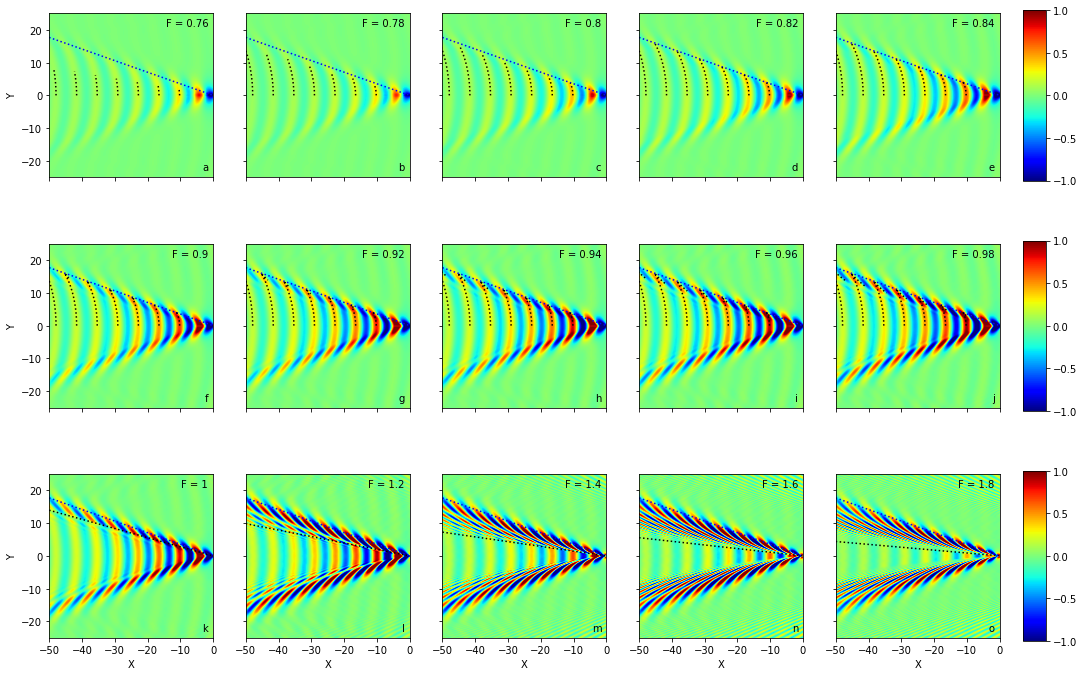

In [7]:
rows = np.array([[0.76, 0.78, 0.8, 0.82, 0.84],
                 [0.9, 0.92, 0.94, 0.96, 0.98],
                 [1, 1.2, 1.4, 1.6, 1.8]])
bounds = np.array([[1.5, 2, 2, 2, 2],
                   [2.5, 2.5, 2.5, 2.5, 2.5],
                   [3, 3, 3, 2.5, 2.5]])

scales = [False, False, True]

xbounds = [-50, 0]
ybounds = [-25, 25]
npy, npx = rows.shape
    
fig = plt.figure(figsize=(16, 12))
axs, imgs = [None, None, None], [None, None, None]
label = 'a'

a = 3.1

for j in range(npy):
    for i in range(npx):
        ax = fig.add_subplot(npy, npx, j*npx + i + 1)
        fr = rows[j, i]
        
        ax.set_xlim(xbounds)
        ax.set_ylim(ybounds)
        ax.text(0.97, 0.97, r'F = %g' % fr, transform=ax.transAxes, 
                    horizontalalignment='right', 
                    verticalalignment='top')
        ax.text(0.97, 0.03, label, transform=ax.transAxes,
                    horizontalalignment='right',
                    verticalalignment='bottom')
        label = chr(ord(label) + 1)
        
        img = draw_wake_plot(ax, Xdict[fr], Pdict[fr], scale=scales[j], bound=bounds[j, i])
        draw_kelvin_angle(ax, Xdict[fr])
        T = calc_T_value(fr, a=a)
        if j in [0, 1]:
            t = np.linspace(1, T, 10000)
            draw_parametric_wake(ax, 8, t, color='black')
            nlbls = len(ax.get_xticklabels())
            ax.set_xticklabels([''] * nlbls)
        elif j == 2:
            draw_inner_angle(ax, Xdict[fr], T, color='black')
            ax.set_xlabel('X')

        if i == 0:
            ax.set_ylabel('Y')
        else:
            #Clear tick labels
            nlbls = len(ax.get_yticklabels())
            ax.set_yticklabels([''] * nlbls)
        axs[j] = ax
        imgs[j] = img

#Add colorbars
fig.subplots_adjust(right=0.95)
for j in range(npy):
    bb = axs[j].get_position().bounds
    cbar_ax = fig.add_axes([0.97, bb[1]+0.0125, 0.02, bb[3]-0.025])
    fig.colorbar(imgs[j], cax=cbar_ax, ticks=[-1, -0.5, 0, 0.5, 1.0])

plt.show()